In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST

from graphviz import Digraph

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 96
LABEL_SIZE = 10
CUDA = True

# MNIST DATA

In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

# GAN

## Discriminator

In [4]:
class Discriminator(nn.Module):
    np.random.seed(0)
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = torch.nn.Linear(784 + LABEL_SIZE, 512, bias=True)
        self.linear2 = torch.nn.Linear(512, 256, bias=True)
        self.linear3 = torch.nn.Linear(256, 1, bias=True)
        
        # Xavier Initialization
        self._init_weight(self.linear1)
        self._init_weight(self.linear2)
        self._init_weight(self.linear3)
    
    def _init_weight(self, layer):
        layer.weight = torch.nn.init.xavier_normal(layer.weight)
        
    def forward(self, x, y):
#         print(x.size())
        x = x.view((-1, 784))
        inputs = torch.cat([x, y], 1)
        
        h = self.linear1(inputs)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.linear2(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        out = self.linear3(h)
        # LSGAN에서 sigmoid 사용하면 안됨
        return out
        

D = Discriminator()
if CUDA:
    print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator(
  (linear1): Linear(in_features=794, out_features=512)
  (linear2): Linear(in_features=512, out_features=256)
  (linear3): Linear(in_features=256, out_features=1)
)


## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        np.random.seed(0)
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100 + LABEL_SIZE, 196)
        self.linear2 = nn.Linear(196, 256)
        self.linear3 = nn.Linear(256, 320)
        self.linear4 = nn.Linear(320, 384)
        self.linear5 = nn.Linear(384, 512)
        self.linear6 = nn.Linear(512, 640)
        self.linear7 = nn.Linear(640, 784)
        
        self.bc1 = nn.BatchNorm1d(196)
        self.bc2 = nn.BatchNorm1d(256)
        self.bc3 = nn.BatchNorm1d(320)
        self.bc4 = nn.BatchNorm1d(384)
        self.bc5 = nn.BatchNorm1d(512)
        self.bc6 = nn.BatchNorm1d(640)
        self.bc7 = nn.BatchNorm1d(784)
        
        
        # Xavier Initialization
        self._init_weight(self.linear1)
        self._init_weight(self.linear2)
        self._init_weight(self.linear3)
        self._init_weight(self.linear4)
    
    def _init_weight(self, layer):
        layer.weight = torch.nn.init.xavier_normal(layer.weight)
        
    def forward(self, x, y):
        inputs = torch.cat([x, y], 1)
        
        h = self.linear1(inputs)
        h = self.bc1(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear2(h)
        h = self.bc2(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear3(h)
        h = self.bc3(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear4(h)
        h = self.bc4(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear5(h)
        h = self.bc5(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear6(h)
        h = self.bc6(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.linear7(h)
        out = F.sigmoid(h)
        return out
        
G = Generator()
if CUDA:
    print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator(
  (linear1): Linear(in_features=110, out_features=196)
  (linear2): Linear(in_features=196, out_features=256)
  (linear3): Linear(in_features=256, out_features=320)
  (linear4): Linear(in_features=320, out_features=384)
  (linear5): Linear(in_features=384, out_features=512)
  (linear6): Linear(in_features=512, out_features=640)
  (linear7): Linear(in_features=640, out_features=784)
  (bc1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (bc3): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True)
  (bc4): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True)
  (bc5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (bc6): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True)
  (bc7): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True)
)


# Train

* $ 1 $ : real images
* $ 0 $ : fake images

In [6]:
N_EPOCH = 100

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [7]:
for epoch in range(N_EPOCH):
    for step, (real_images, y) in enumerate(train_loader):
        # Samples
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        
        y = y.view(-1, 1)
        y_onehot = torch.FloatTensor(BATCH_SIZE, LABEL_SIZE)
        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)
        y_onehot = Variable(y_onehot).cuda()
        
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images, y_onehot)
        d_real_loss = 0.5*torch.mean(torch.pow(y_real_pred - real_y, 2))
#         d_real_loss = loss_f(y_real_pred, real_y)
#         d_real_loss.backward()
#         d_optimizer.step()
        
        # Calculate the loss with fake images
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions, y_onehot).detach()
        y_fake_pred = D(fake_images, y_onehot)
        d_fake_loss = 0.5*torch.mean(torch.pow(y_fake_pred - fake_y, 2))
        
#         d_fake_loss = loss_f(y_fake_pred, fake_y)
#         d_fake_loss.backward()
#         d_optimizer.step()
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions, y_onehot)
        y_pred = D(fake_images, y_onehot)
        g_loss = 0.5*torch.mean(torch.pow(y_pred - real_y, 2))
        g_loss.backward()
        g_optimizer.step()
        
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
    print()

[1/100] divergence: 1.0      D: 7.35e-06 D_real: 3.45e-05 D_fake: 7.35e-06 G:0.5     
[2/100] divergence: 1.0      D: 0.000379 D_real: 9.84e-05 D_fake: 0.000379 G:0.499   
[3/100] divergence: 0.999    D: 0.000464 D_real: 0.000109 D_fake: 0.000464 G:0.499   
[4/100] divergence: 0.999    D: 0.000652 D_real: 0.000242 D_fake: 0.000652 G:0.499   
[5/100] divergence: 0.999    D: 0.000626 D_real: 0.000492 D_fake: 0.000626 G:0.499   
[6/100] divergence: 0.997    D: 0.00162  D_real: 0.000588 D_fake: 0.00162  G:0.497   
[7/100] divergence: 0.999    D: 0.00101  D_real: 0.00044  D_fake: 0.00101  G:0.499   
[8/100] divergence: 0.994    D: 0.00273  D_real: 0.0012   D_fake: 0.00273  G:0.495   
[9/100] divergence: 0.992    D: 0.00369  D_real: 0.00198  D_fake: 0.00369  G:0.492   
[10/100] divergence: 0.987    D: 0.00567  D_real: 0.00382  D_fake: 0.00567  G:0.488   
[11/100] divergence: 0.983    D: 0.00743  D_real: 0.00434  D_fake: 0.00743  G:0.483   
[12/100] divergence: 0.98     D: 0.00743  D_real: 0.

# Visualization

In [8]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

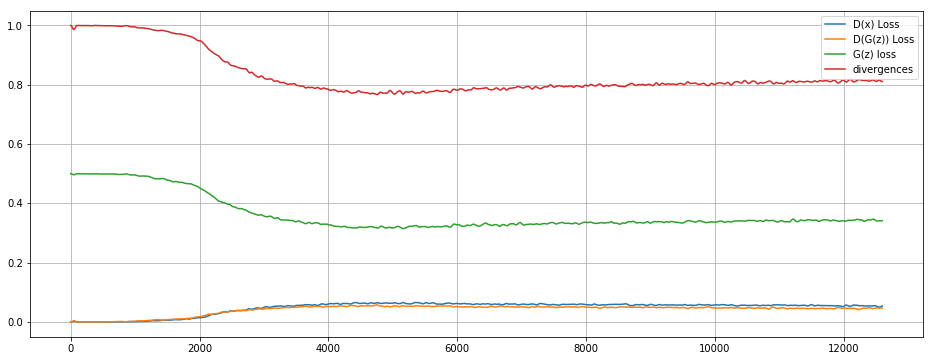

In [9]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

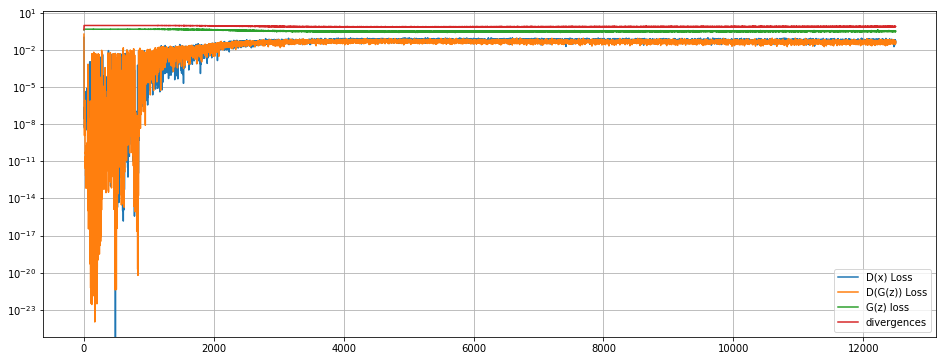

In [10]:
plot(d_real_losses, label='D(x) Loss')
plot(d_fake_losses, label='D(G(z)) Loss')
plot(g_losses, label='G(z) loss')
plot(divergences, label='divergences')

yscale('log')
grid()
legend()

# Evaluate

In [11]:
y = np.random.randint(0, 10, BATCH_SIZE)
y_onehot = np.zeros((BATCH_SIZE, LABEL_SIZE))
y_onehot[np.arange(BATCH_SIZE), y] = 1
y_onehot = Variable(torch.FloatTensor(y_onehot))
if CUDA:
    y_onehot = y_onehot.cuda()

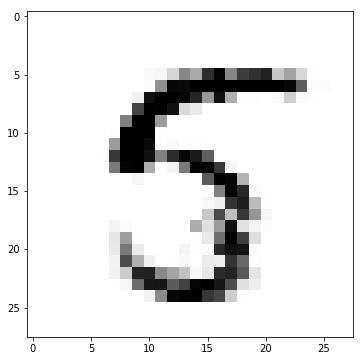

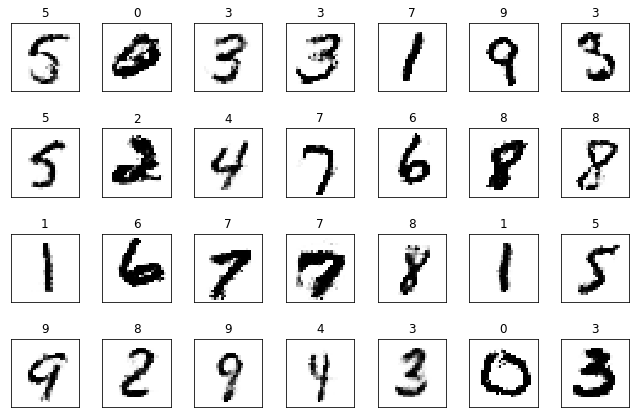

In [13]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions, y_onehot).view((-1, 28, 28)).data.cpu().numpy()

imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(4, 7) # subplots(y축, x축 갯수)
fig.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(9)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        label = y[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.set_title(label)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1
